# Import

In [2]:
import pandas as pd

try:
    df_insurance = pd.read_csv('insurance.csv')
    display(df_insurance.head())
    print(df_insurance.shape)
except FileNotFoundError:
    print("Error: 'insurance.csv' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


(1338, 7)


# Exploração de dados:

### Null and estatisticas

In [3]:
# Tipos dos dados
print("Data Types:\n", df_insurance.dtypes)

#Avaliando colunas nulas
null_values = df_insurance.isnull().sum()
null_values_percentage = (null_values / len(df_insurance)) * 100
print("\n Null Values:\n", null_values)
print("\n Null Value Percentage:\n", null_values_percentage)

# Avaliando campos numericos
numerical_features = ['age', 'bmi', 'children', 'charges']
print("\n Statistics for Numerical Features: \n", df_insurance[numerical_features].describe())

# Avaliando campos descritivos
categorical_features = ['sex', 'smoker', 'region']
for col in categorical_features:
    print(f"\n Statistics for {col}: \n{df_insurance[col].value_counts()}")

Data Types:
 age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

 Null Values:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

 Null Value Percentage:
 age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

 Statistics for Numerical Features: 
                age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.0000

### Visualização dos dados

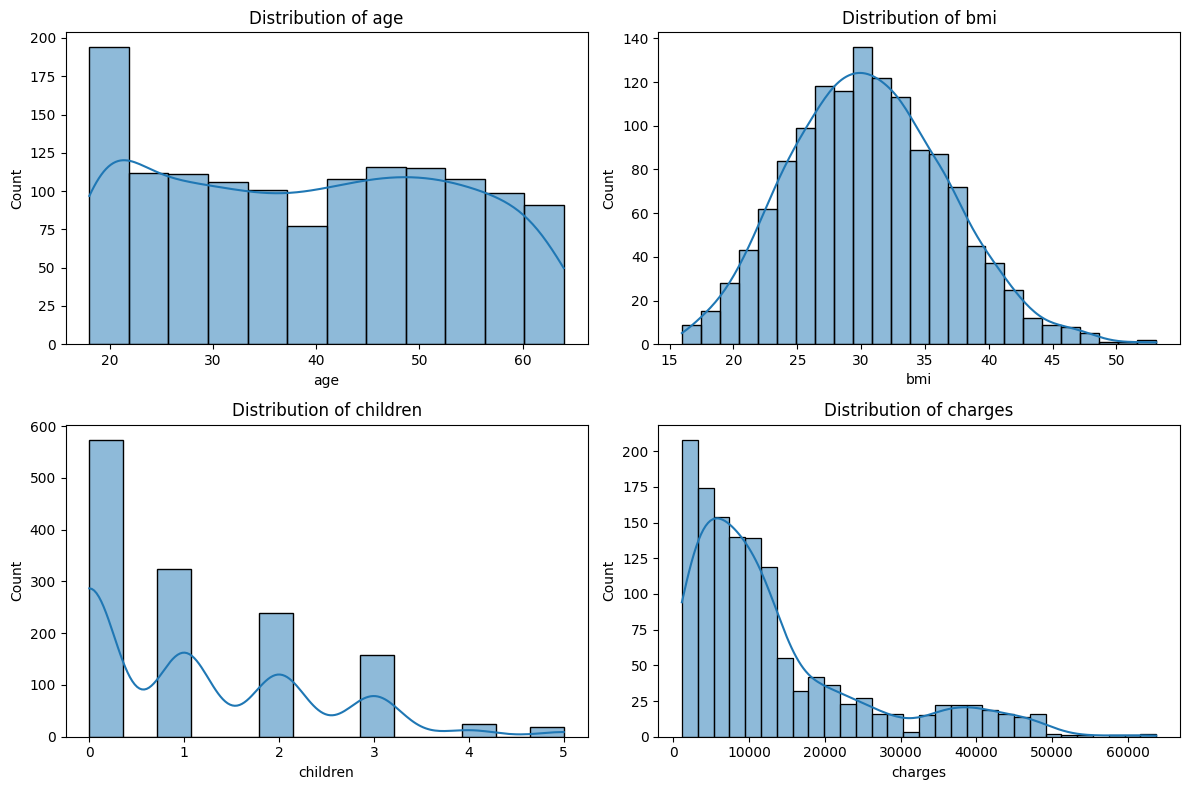

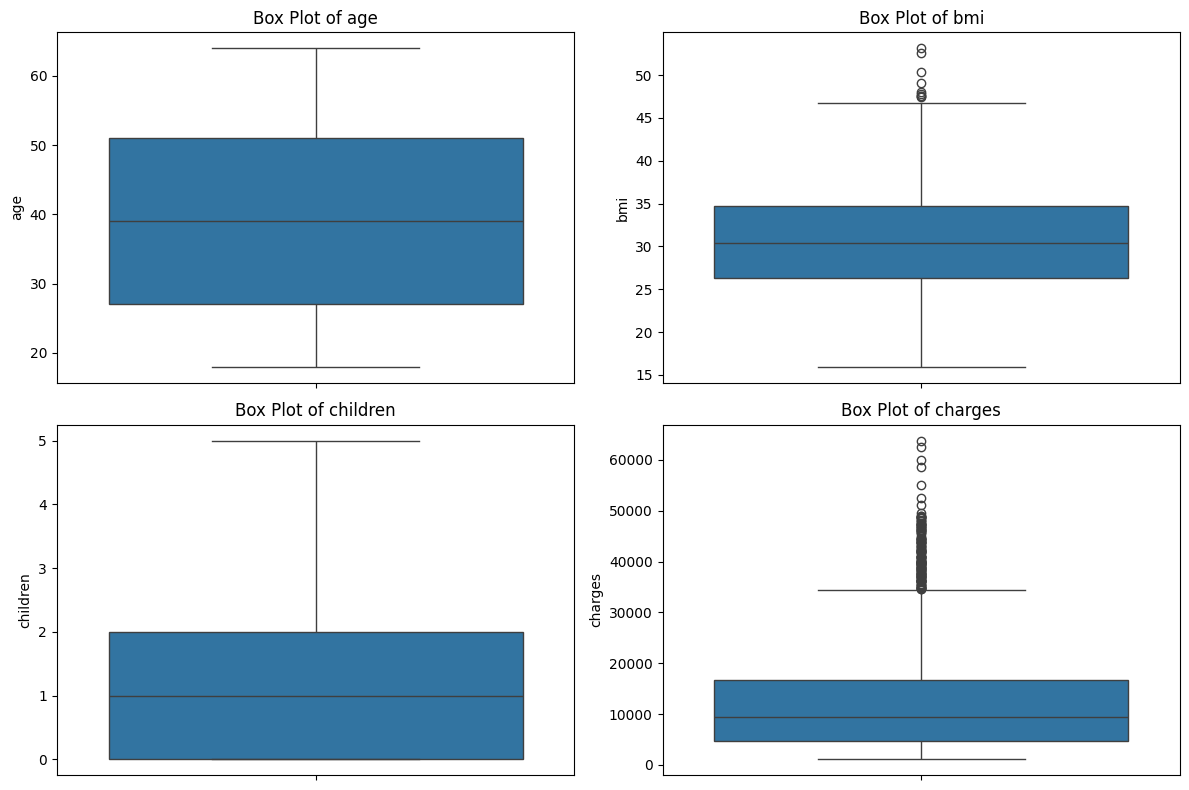

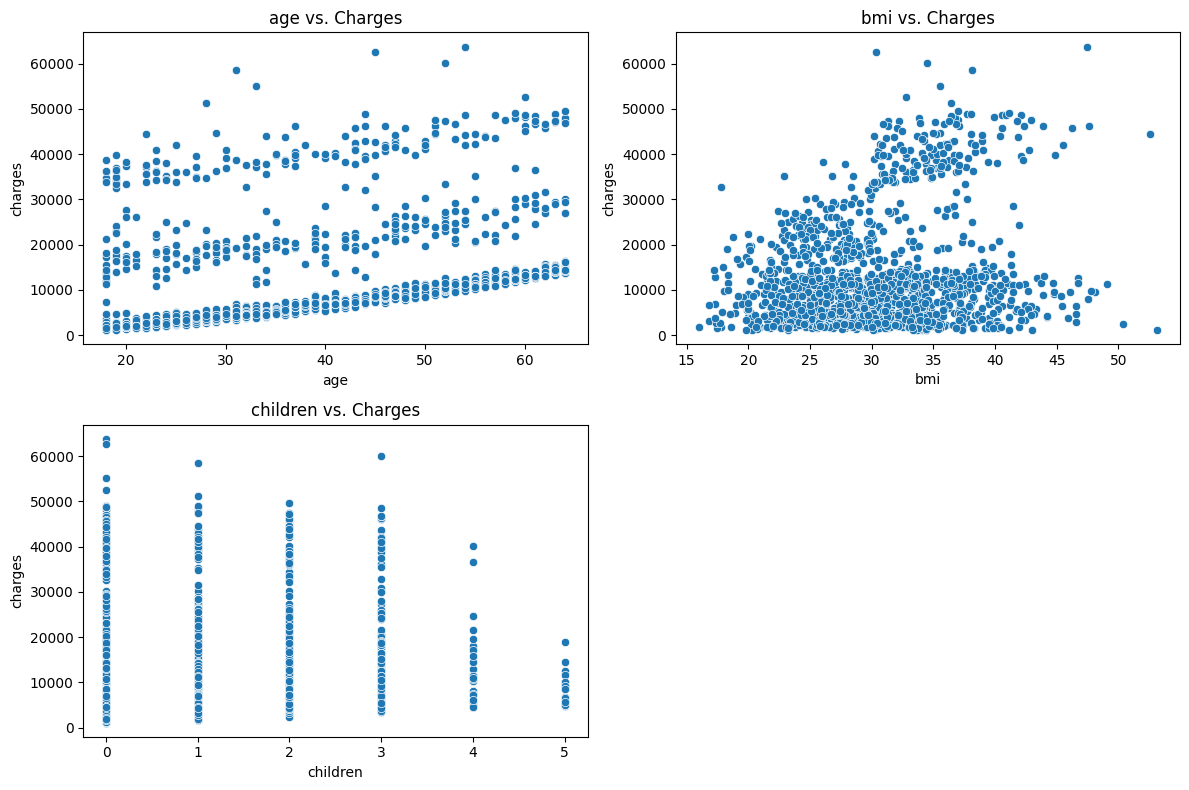

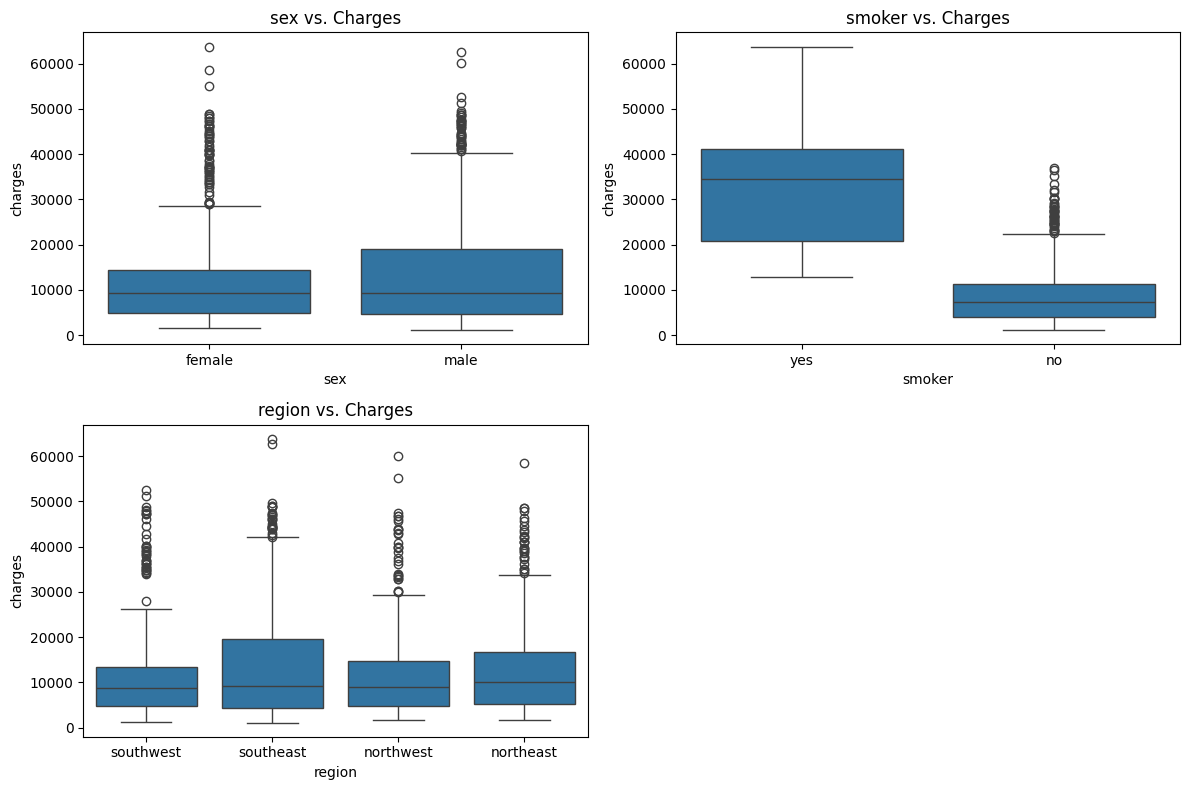

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogramas para campos numericos
plt.figure(figsize=(12, 8))
for i, col in enumerate(['age', 'bmi', 'children', 'charges']):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df_insurance[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Box plots para campos numericos
plt.figure(figsize=(12, 8))
for i, col in enumerate(['age', 'bmi', 'children', 'charges']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(y=df_insurance[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

# Scatter plots de metricas numericas vs charge
plt.figure(figsize=(12, 8))
for i, col in enumerate(['age', 'bmi', 'children']):
    plt.subplot(2, 2, i + 1)
    sns.scatterplot(x=df_insurance[col], y=df_insurance['charges'])
    plt.title(f'{col} vs. Charges')
plt.tight_layout()
plt.show()

# Campos categoricos vs 'charges'
plt.figure(figsize=(12, 8))
for i, col in enumerate(['sex', 'smoker', 'region']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x=df_insurance[col], y=df_insurance['charges'])
    plt.title(f'{col} vs. Charges')
plt.tight_layout()
plt.show()

# Pré-processamento de dados:

### Limpeza

In [ ]:
import numpy as np

# Usando Log para remover outlier de 'charges'
df_insurance['charges'] = np.log1p(df_insurance['charges'])

# Cap 'bmi' at the 99th percentile
bmi_99th = df_insurance['bmi'].quantile(0.99)
df_insurance['bmi'] = np.where(df_insurance['bmi'] > bmi_99th, bmi_99th, df_insurance['bmi'])

# Removendo outliers in 'age' and 'children'
age_99th = df_insurance['age'].quantile(0.99)
df_insurance = df_insurance[df_insurance['age'] <= age_99th]

children_99th = df_insurance['children'].quantile(0.99)
df_insurance = df_insurance[df_insurance['children'] <= children_99th]

# Define numerical columns
numerical_cols = ['age', 'bmi', 'children', 'charges']


if df_insurance.isnull().values.any():
    
    for col in numerical_cols:
        if df_insurance[col].isnull().any():
            df_insurance[col] = df_insurance[col].fillna(df_insurance[col].median())
    print('Missing values imputed with median.')
else:
    print('No missing values found.')

# Display summary statistics of cleaned numerical features
print("\n Descriptive Statistics for Numerical Features after cleaning: \n", df_insurance[numerical_cols].describe())

### Conversão de dados

In [ ]:
# Perform one-hot encoding on categorical features
df_encoded = pd.get_dummies(df_insurance, columns=['sex', 'smoker', 'region'], drop_first=True)

# Display the first few rows of the encoded DataFrame
display(df_encoded.head())

### Engenharia de campos (Vale muito a ver se isso impacta algo rsrs)

In [ ]:
# Create interaction terms
df_encoded['age_bmi'] = df_encoded['age'] * df_encoded['bmi']

# Create polynomial features
df_encoded['age_squared'] = df_encoded['age'] ** 2
df_encoded['bmi_squared'] = df_encoded['bmi'] ** 2


# Examine the correlation matrix
numeric_df = df_encoded.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr()['charges']
print(correlation_matrix)

# Modelagem

### Separação treino e teste

In [ ]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df_encoded['smoker_yes'])

# Treinamento e avaliação do modelo:

### Treinamento de modelo

In [ ]:
from sklearn.linear_model import LinearRegression

# Initialize the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

### Avaliação de modelo

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Print the evaluation metrics
print(f"R-squared: {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

### Otimização de modelo (Gerado pelo gemini, não sei se faz sentido)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Define the parameter grid for Ridge regression
param_grid = {'alpha': [0.1, 1, 10, 100]}

# Initialize the Ridge regression model
ridge = Ridge()

# Perform GridSearchCV
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the best model
best_alpha = grid_search.best_params_['alpha']
best_ridge_model = grid_search.best_estimator_

# Train the Ridge regression model with the best hyperparameters
best_ridge_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_ridge = best_ridge_model.predict(X_test)

# Evaluate the model
r2_ridge = r2_score(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)

# Print the results
print(f"Best alpha: {best_alpha}")
print(f"Ridge R-squared: {r2_ridge}")
print(f"Ridge MSE: {mse_ridge}")
print(f"Ridge RMSE: {rmse_ridge}")

# Compare with the initial linear regression model (assuming results are available)
# (Add code to access and print initial linear regression results here if available)

# Validação estatística

### Essa parte eu nao tinha feito, mas vou montar algo sobre